# Segmentation Model Training

##### 1. IMPORTS AND SETUP


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import segmentation_models_pytorch as smp
import json
from datetime import datetime

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 2050


#### 2. CONFIGURATION


In [24]:
class Config:
    """Training configuration"""
    # Model
    MODEL_NAME = "deeplabv3plus"
    BACKBONE = "resnet50"
    IN_CHANNELS = 3
    NUM_CLASSES = 1  # Binary segmentation (piece vs background)
    
    # Data
    IMG_SIZE = (256, 256)  # Resize images to this size
    BATCH_SIZE = 8
    NUM_WORKERS = 0
    
    # Training
    EPOCHS = 5
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4
    
    # Paths (relative to notebooks directory)
    TRAIN_IMG_DIR = "../data/train/images"
    TRAIN_MASK_DIR = "../data/train/masks"
    VAL_IMG_DIR = "../data/val/images"
    VAL_MASK_DIR = "../data/val/masks"
    TEST_IMG_DIR = "../data/test/images"
    TEST_MASK_DIR = "../data/test/masks"
    
    # Output paths
    MODEL_DIR = "../output/training"
    OUTPUT_DIR = "../output/training"
    
    # Create directories
    Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
    Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

config = Config()

print("\n" + "="*70)
print("CONFIGURATION")
print("="*70)
print(f"Model: {config.MODEL_NAME} with {config.BACKBONE} backbone")
print(f"Image size: {config.IMG_SIZE}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Epochs: {config.EPOCHS}")
print(f"Learning rate: {config.LEARNING_RATE}")


CONFIGURATION
Model: deeplabv3plus with resnet50 backbone
Image size: (256, 256)
Batch size: 8
Epochs: 5
Learning rate: 0.0001


#### 3. DATASET CLASS


In [25]:
class PuzzleDataset(Dataset):
    """Dataset for puzzle piece segmentation"""
    
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        
        # Get all image files
        self.image_files = sorted(list(self.img_dir.glob("*.jpg")))
        
        print(f"Found {len(self.image_files)} images in {img_dir}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        try:
            # Load image
            img_path = self.image_files[idx]
            image = np.array(Image.open(img_path).convert("RGB"))
            
            # Load mask
            mask_name = img_path.stem + "_mask.png"
            mask_path = self.mask_dir / mask_name
            mask = np.array(Image.open(mask_path).convert("L"))
            
            # Normalize mask to 0 and 1
            mask = (mask > 0).astype(np.float32)
            
            # Apply transformations
            if self.transform:
                transformed = self.transform(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]
            
            return image, mask.unsqueeze(0)  # Add channel dimension to mask
        except Exception as e:
            print(f"Error loading {self.image_files[idx]}: {e}")
            raise

#### 4. DATA AUGMENTATION


In [26]:
def get_train_transform(img_size):
    """Training data augmentation"""
    return A.Compose([
        A.Resize(height=img_size[0], width=img_size[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # Small rotations, translations, and scaling
        A.Affine(
            translate_percent={"x": 0.1, "y": 0.1},
            rotate=(-15, 15),
            scale=(0.9, 1.1),  # uniform scaling
            p=0.5
        ),
        # Normalize for pretrained encoder
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

def get_val_transform(img_size):
    """Validation data augmentation (no augmentation, just normalization)"""
    return A.Compose([
        A.Resize(height=img_size[0], width=img_size[1]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

### 5. CREATE DATALOADERS


In [27]:
print("\n" + "="*70)
print("CREATING DATALOADERS")
print("="*70)

# Create datasets
train_dataset = PuzzleDataset(
    config.TRAIN_IMG_DIR,
    config.TRAIN_MASK_DIR,
    transform=get_train_transform(config.IMG_SIZE)
)

val_dataset = PuzzleDataset(
    config.VAL_IMG_DIR,
    config.VAL_MASK_DIR,
    transform=get_val_transform(config.IMG_SIZE)
)

test_dataset = PuzzleDataset(
    config.TEST_IMG_DIR,
    config.TEST_MASK_DIR,
    transform=get_val_transform(config.IMG_SIZE)
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)

print(f"\n✓ Training batches: {len(train_loader)}")
print(f"✓ Validation batches: {len(val_loader)}")
print(f"✓ Test batches: {len(test_loader)}")


CREATING DATALOADERS
Found 350 images in ../data/train/images
Found 75 images in ../data/val/images
Found 75 images in ../data/test/images

✓ Training batches: 44
✓ Validation batches: 10
✓ Test batches: 10


#### 6. MODEL INITIALIZATION


In [28]:
print("\n" + "="*70)
print("INITIALIZING MODEL")
print("="*70)

# Create model
model = smp.DeepLabV3Plus(
    encoder_name=config.BACKBONE,
    encoder_weights="imagenet",
    in_channels=config.IN_CHANNELS,
    classes=config.NUM_CLASSES
).to(device)

print(f"Model created: DeepLabV3+ with {config.BACKBONE} backbone")
print(f"Encoder initialized with ImageNet weights")


INITIALIZING MODEL
Model created: DeepLabV3+ with resnet50 backbone
Encoder initialized with ImageNet weights


#### 7. LOSS FUNCTION AND METRICS


In [29]:
class DiceLoss(nn.Module):
    """Dice Loss for binary segmentation"""
    
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        pred = pred.view(-1)
        target = target.view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined BCE and Dice Loss"""
    
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, pred, target):
        return self.bce(pred, target) + self.dice(pred, target)

def calculate_iou(pred, target, threshold=0.5):
    """Calculate Intersection over Union (IoU)"""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    target = target.float()
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou.item()

# Initialize loss
criterion = CombinedLoss()
print("\nLoss function: Combined BCE + Dice Loss")


Loss function: Combined BCE + Dice Loss


#### 8. OPTIMIZER AND SCHEDULER


In [30]:
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5
)

print("Optimizer: AdamW")
print("Scheduler: ReduceLROnPlateau (monitors validation IoU)")

Optimizer: AdamW
Scheduler: ReduceLROnPlateau (monitors validation IoU)


#### 9. TRAINING LOOP

In [31]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    
    pbar = tqdm(loader, desc="Training")
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        iou = calculate_iou(outputs, masks)
        
        running_loss += loss.item()
        running_iou += iou
        
        pbar.set_postfix({'loss': loss.item(), 'iou': iou})
    
    epoch_loss = running_loss / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_iou

def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc="Validation")
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            iou = calculate_iou(outputs, masks)
            
            running_loss += loss.item()
            running_iou += iou
            
            pbar.set_postfix({'loss': loss.item(), 'iou': iou})
    
    epoch_loss = running_loss / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_iou

#### 10. TRAINING


In [32]:
print("\n" + "="*70)
print("STARTING TRAINING")
print("="*70)

# Training history
history = {
    'train_loss': [],
    'train_iou': [],
    'val_loss': [],
    'val_iou': [],
    'lr': []
}

best_val_iou = 0.0
patience_counter = 0
early_stop_patience = 10

for epoch in range(config.EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.EPOCHS}")
    print("-" * 70)
    
    # Train
    train_loss, train_iou = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_iou = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_iou)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['lr'].append(current_lr)
    
    # Print metrics
    print(f"Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        patience_counter = 0
        
        model_save_path = Path(config.MODEL_DIR) / f"deeplabv3plus_resnet50_best.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_iou': val_iou,
            'config': config.__dict__
        }, model_save_path)
        
        print(f"✓ Best model saved! Val IoU: {val_iou:.4f}")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*70)
print("TRAINING COMPLETE")
print("="*70)
print(f"Best Validation IoU: {best_val_iou:.4f}")


STARTING TRAINING

Epoch 1/5
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it, loss=1.01, iou=0.659]


Train Loss: 1.0997 | Train IoU: 0.4886
Val Loss: 1.0070 | Val IoU: 0.6539
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.6539

Epoch 2/5
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.657, iou=0.696]


Train Loss: 0.7517 | Train IoU: 0.6934
Val Loss: 0.6490 | Val IoU: 0.7303
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.7303

Epoch 3/5
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:17<00:00,  1.72s/it, loss=0.491, iou=0.785]


Train Loss: 0.5591 | Train IoU: 0.7587
Val Loss: 0.4708 | Val IoU: 0.8074
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.8074

Epoch 4/5
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=0.367, iou=0.836]


Train Loss: 0.4056 | Train IoU: 0.8308
Val Loss: 0.3467 | Val IoU: 0.8632
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.8632

Epoch 5/5
----------------------------------------------------------------------


Validation: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=0.271, iou=0.872]


Train Loss: 0.2959 | Train IoU: 0.8818
Val Loss: 0.2437 | Val IoU: 0.8998
Learning Rate: 0.000100
✓ Best model saved! Val IoU: 0.8998

TRAINING COMPLETE
Best Validation IoU: 0.8998


#### 11. PLOT TRAINING HISTORY



PLOTTING TRAINING HISTORY


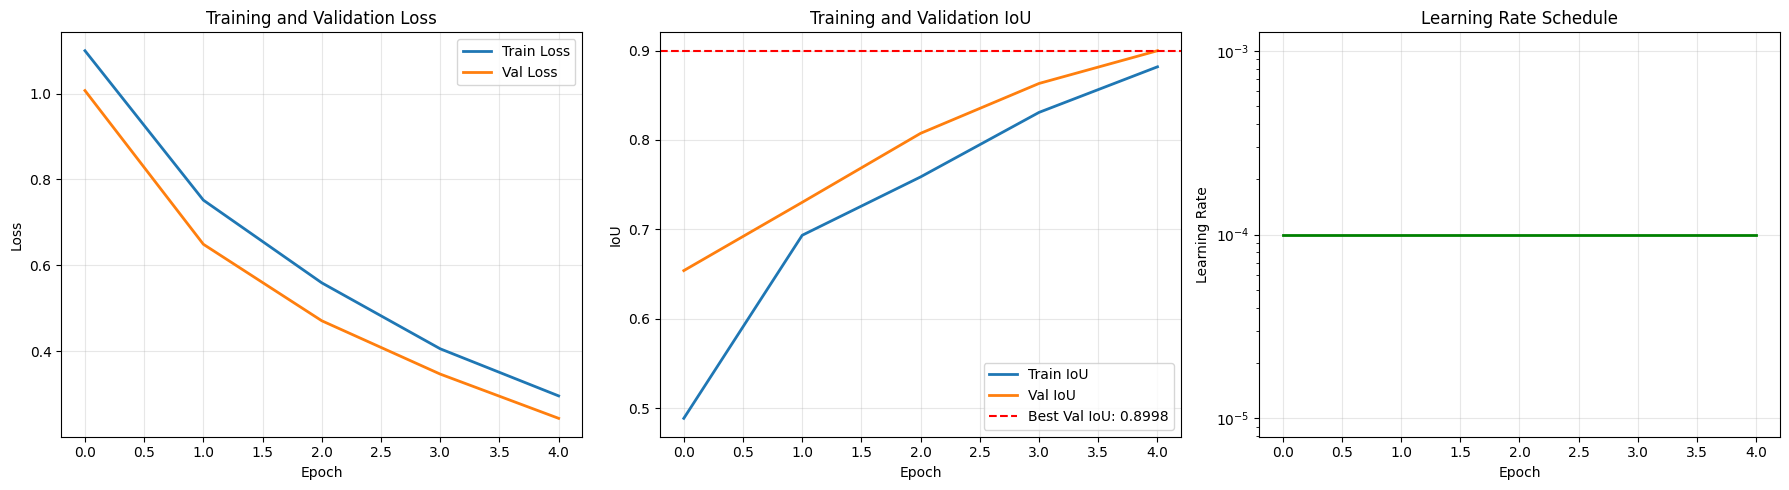

✓ Training history plots saved


In [33]:
print("\n" + "="*70)
print("PLOTTING TRAINING HISTORY")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# IoU
axes[1].plot(history['train_iou'], label='Train IoU', linewidth=2)
axes[1].plot(history['val_iou'], label='Val IoU', linewidth=2)
axes[1].axhline(y=best_val_iou, color='r', linestyle='--', label=f'Best Val IoU: {best_val_iou:.4f}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('Training and Validation IoU')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(history['lr'], linewidth=2, color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{config.OUTPUT_DIR}/deeplabv3plus_resnet50_training_history.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training history plots saved")

#### 12. EVALUATE ON TEST SET


In [34]:
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Load best model
checkpoint = torch.load(Path(config.MODEL_DIR) / "deeplabv3plus_resnet50_best.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print("✓ Loaded best model weights")

# Evaluate
test_loss, test_iou = validate_epoch(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  IoU: {test_iou:.4f}")


EVALUATING ON TEST SET
✓ Loaded best model weights


Validation: 100%|██████████| 10/10 [00:20<00:00,  2.04s/it, loss=0.256, iou=0.902]


Test Results:
  Loss: 0.2409
  IoU: 0.9034


#### 13. VISUALIZE PREDICTIONS


VISUALIZING PREDICTIONS


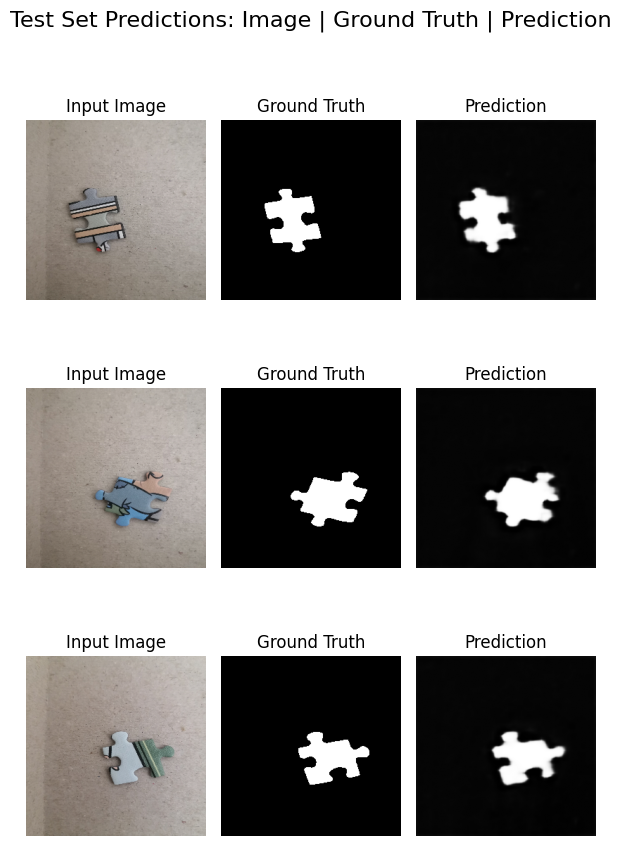

In [39]:
print("\n" + "="*70)
print("VISUALIZING PREDICTIONS")
print("="*70)

model.eval()
n_samples = 3

# Get random samples from test set
test_indices = np.random.choice(len(test_dataset), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 3, figsize=(6, 3*n_samples))
fig.suptitle('Test Set Predictions: Image | Ground Truth | Prediction', fontsize=16, y=1.00)

with torch.no_grad():
    for idx, test_idx in enumerate(test_indices):
        # Get sample
        image, mask = test_dataset[test_idx]
        
        # Predict
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        pred_mask = torch.sigmoid(output).cpu().numpy()[0, 0]
        
        # Denormalize image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_viz = image.permute(1, 2, 0).numpy()
        img_viz = (img_viz * std + mean).clip(0, 1)
        
        # Plot
        axes[idx, 0].imshow(img_viz)
        axes[idx, 0].set_title('Input Image')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(mask[0], cmap='gray')
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred_mask, cmap='gray')
        axes[idx, 2].set_title(f'Prediction')
        axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

#### 14. SAVE FINAL RESULTS


In [ ]:
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

results = {
    'model': config.MODEL_NAME,
    'backbone': config.BACKBONE,
    'image_size': config.IMG_SIZE,
    'batch_size': config.BATCH_SIZE,
    'epochs_trained': len(history['train_loss']),
    'best_val_iou': float(best_val_iou),
    'test_iou': float(test_iou),
    'test_loss': float(test_loss),
    'final_lr': float(history['lr'][-1]),
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'history': {k: [float(v) for v in vals] for k, vals in history.items()}
}

results_path = Path(config.OUTPUT_DIR) / "deeplabv3plus_resnet50_results.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Results saved to {results_path}")

print("\n" + "="*70)
print("EXPERIMENT COMPLETE")
print("="*70)
print(f"\nFinal Results:")
print(f"  Best Validation IoU: {best_val_iou:.4f}")
print(f"  Test IoU: {test_iou:.4f}")


SAVING RESULTS
✓ Results saved to ..\output\training\deeplabv3plus_resnet50_results.json

EXPERIMENT COMPLETE

Final Results:
  Best Validation IoU: 0.8998
  Test IoU: 0.9034
